# STAT3009 Project 1
- LAW Yiu Leung Eric 1155149315
- LAM Wai Chiu 1155152095
- TSOI Tung Sing 1155127274

## Import packages and load the developed methods

In [27]:
import numpy as np
import pandas as pd

In [ ]:
def rmse(true, pred):
	return np.sqrt(np.mean((pred - true)**2))

# baseline methods
class glb_mean(object):
	def __init__(self):
		self.glb_mean = 0
	
	def fit(self, train_ratings):
		self.glb_mean = np.mean(train_ratings)
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))
		pred = pred*self.glb_mean
		return pred

class user_mean(object):
	def __init__(self, n_user):
		self.n_user = n_user
		self.glb_mean = 0.
		self.user_mean = np.zeros(n_user)
	
	def fit(self, train_pair, train_ratings):
		self.glb_mean = train_ratings.mean()
		for u in range(self.n_user):
			ind_train = np.where(train_pair[:,0] == u)[0]
			if len(ind_train) == 0:
				self.user_mean[u] = self.glb_mean
			else:
				self.user_mean[u] = train_ratings[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.user_mean[user_tmp]
			j = j + 1
		return pred

class item_mean(object):
	def __init__(self, n_item):
		self.n_item = n_item
		self.glb_mean = 0.
		self.item_mean = np.zeros(n_item)
	
	def fit(self, train_pair, train_ratings):
		self.glb_mean = train_ratings.mean()
		for i in range(self.n_item):
			ind_train = np.where(train_pair[:,1] == i)[0]
			if len(ind_train) == 0:
				self.item_mean[i] = self.glb_mean
			else:
				self.item_mean[i] = train_ratings[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.item_mean[item_tmp]
			j = j + 1
		return pred


class LFM(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=10, tol=1e-4, verbose=1):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol
        self.verbose = verbose

    def fit(self, train_pair, train_rating, learning_rate=0.0001):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        if self.verbose:
            print('Fitting Reg-LFM: K: %d, lam: %.5f' %(K, lam))
        for i in range(iterNum):
            ## item update
            score_old = self.rmse(test_pair=train_pair, test_rating=train_rating)
            for j in range(n_obs):
                user_id, item_id, rating_tmp = train_pair[j,0], train_pair[j,1], train_rating[j]
                err_tmp = rating_tmp - np.dot(self.P[user_id,:], self.Q[item_id,:])
                self.Q[item_id,:] = self.Q[item_id,:] + 2*learning_rate*err_tmp*self.P[user_id,:] - 2*learning_rate*lam*self.Q[item_id,:]
                err_tmp = rating_tmp - np.dot(self.P[user_id,:], self.Q[item_id,:])
                self.P[user_id,:] = self.P[user_id,:] + 2*learning_rate*self.Q[item_id,:] - 2*learning_rate*lam*self.P[user_id,:]
            # compute the new rmse score
            score_new = self.rmse(test_pair=train_pair, test_rating=train_rating)
            diff = - score_new + score_old
            if self.verbose:
                print("Reg-LFM: ite: %d; diff: %.3f RMSE: %.3f" %(i, diff, score_new))
            if (diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)
    
    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `LFM`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

from sklearn.model_selection import KFold
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class LFM_CV(object):

	def __init__(self, n_user, n_item, cv=5,
				lams=[.000001,.0001,.001,.01], 
				Ks=[3,5,10,20], 
				iterNum=10, tol=1e-4):
		# self.index_item = []
		# self.index_user = []
		self.n_user = n_user
		self.n_item = n_item
		self.cv = cv
		self.lams = lams
		self.Ks = Ks
		self.iterNum = iterNum
		self.tol = tol
		self.best_model = {}
		self.cv_result = {'K': [], 'lam': [], 'train_rmse': [], 'valid_rmse': []}

	def grid_search(self, train_pair, train_rating):
		## generate all comb of `K` and `lam`
		kf = KFold(n_splits=self.cv, shuffle=True)
		for (K,lam) in itertools.product(self.Ks, self.lams):
			train_rmse_tmp, valid_rmse_tmp = 0., 0.
			for train_index, valid_index in kf.split(train_pair):
				# produce training/validation sets
				train_pair_cv, train_rating_cv = train_pair[train_index], train_rating[train_index]
				valid_pair_cv, valid_rating_cv = train_pair[valid_index], train_rating[valid_index]
				# fit the model based on CV data
				model_tmp = LFM(self.n_user, self.n_item, K=K, lam=lam, verbose=0)
				model_tmp.fit(train_pair=train_pair_cv, train_rating=train_rating_cv)
				train_rmse_tmp_cv = model_tmp.rmse(test_pair=train_pair_cv, test_rating=train_rating_cv)
				valid_rmse_tmp_cv = model_tmp.rmse(test_pair=valid_pair_cv, test_rating=valid_rating_cv)
				train_rmse_tmp = train_rmse_tmp + train_rmse_tmp_cv / self.cv
				valid_rmse_tmp = valid_rmse_tmp + valid_rmse_tmp_cv / self.cv
				print('%d-Fold CV for K: %d; lam: %.5f: train_rmse: %.3f, valid_rmse: %.3f' 
						%(self.cv, K, lam, train_rmse_tmp_cv, valid_rmse_tmp_cv))
			self.cv_result['K'].append(K)
			self.cv_result['lam'].append(lam)
			self.cv_result['train_rmse'].append(train_rmse_tmp)
			self.cv_result['valid_rmse'].append(valid_rmse_tmp)
		self.cv_result = pd.DataFrame.from_dict(self.cv_result)
		best_ind = self.cv_result['valid_rmse'].argmin()
		self.best_model = self.cv_result.loc[best_ind]
	
	def plot_grid(self, data_source='valid'):
		sns.set_theme()
		if data_source == 'train':
			cv_pivot = self.cv_result.pivot("K", "lam", "train_rmse")
		elif data_source == 'valid':
			cv_pivot = self.cv_result.pivot("K", "lam", "valid_rmse")
		else:
			raise ValueError('data_source must be train or valid!')
		sns.heatmap(cv_pivot, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
		plt.show()

# Pre-process the raw data
- check the `user_id` and `item_id`: mapping `item_id` to a continuous sequence based on `sklean.preprocessing`
- create `train_pair`,`train_rating`, `test_pair`

This part is contributed by `TSOI Tung Sing 1155127274`

In [28]:
dtrain = pd.read_csv("data/train.csv")
dtest = pd.read_csv("data/test.csv")

## mapping 
from sklearn import preprocessing
le_user = preprocessing.LabelEncoder()
le_user.fit(np.append(dtrain['user_id'], dtest["user_id"]))
dtrain['user_id'] = le_user.transform(dtrain["user_id"])
dtest["user_id"] = le_user.transform(dtest["user_id"])

le_item = preprocessing.LabelEncoder()
le_item.fit(np.append(dtrain['item_id'], dtest["item_id"]))
dtrain["item_id"] = le_item.transform(dtrain["item_id"])
dtest["item_id"] = le_item.transform(dtest["item_id"])

Create train_pair, train_rating and test_pair

In [29]:
# train_pair, train_rating
train_pair = dtrain[['user_id', 'item_id']].values
train_rating = dtrain['rating'].values

# test_pair
test_pair = dtest[['user_id', 'item_id']].values

n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1

# Exploratory Data Analysis (EDA)
This part is contributed by `LAM Wai Chiu 1155152095`

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

## Summary of the Dataset

In [83]:
print("Number of users: {n_user}\nNumber of items: {n_item}".format(n_user = n_user, n_item = n_item))
print("Number of records (rows): {n_rows}".format(n_rows = len(dtrain)))
print("Unique ratings: ", list(set(dtrain["rating"])))

Number of users: 492
Number of items: 959
Number of records (rows): 15303
Unique ratings:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


The target variable is `rating`, which is discrete within [0, 15]. The explanatory variables are `user_id` and `item_id`, they are both nominal categorical data.

## Histogram of Ratings

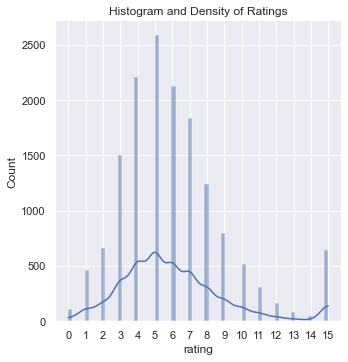

In [32]:
g = sns.displot(dtrain, x = "rating", kde = True, fill = True)
g.set(title = "Histogram and Density of Ratings", xticks = np.arange(15+1))
plt.show(g)

The mode of rating is 5, it seems to be normally distributed with mean = 5, except 15 being an outlier

## Histogram of Users and Items


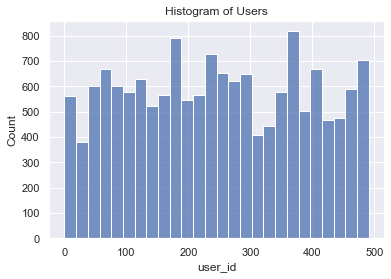

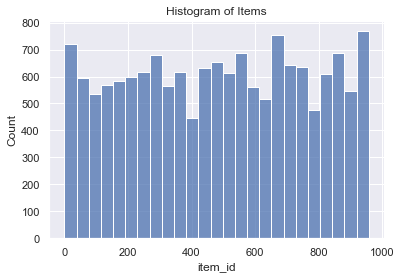

In [33]:
# histogram of users
g = sns.histplot(data = dtrain, x = "user_id")
g.set_title("Histogram of Users")
plt.show(g)

# histogram of items
g = sns.histplot(data = dtrain, x = "item_id")
g.set_title("Histogram of Items")
plt.show(g)

## Histogram for Averaged Ratings for Users and Items

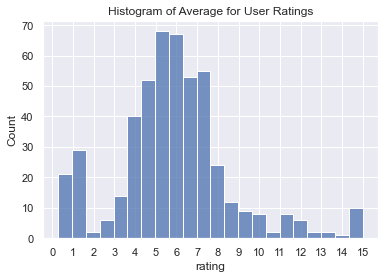

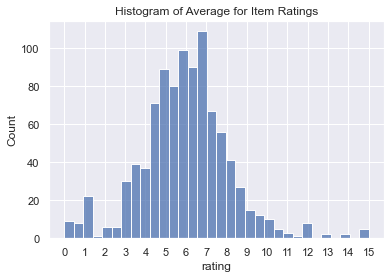

In [34]:
# Histogram of average for user ratings
g = sns.histplot(x = dtrain.groupby("user_id")["rating"].mean())
g.set_xticks(range(15+1))
g.set_title("Histogram of Average for User Ratings")
plt.show(g)

# Histogram of average for item ratings
g = sns.histplot(x = dtrain.groupby("item_id")["rating"].mean())
g.set_xticks(range(15+1))
g.set_title("Histogram of Average for Item Ratings")
plt.show(g)

## Find Top-20 highest Rating Items
Calculate the average rating of each items, then find the top 20

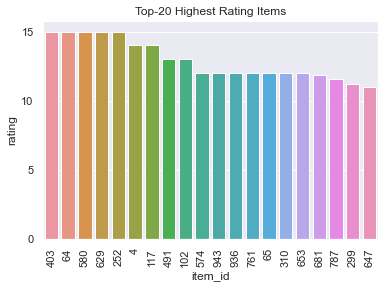

In [84]:
top20_item = dtrain.groupby("item_id")["rating"].mean().sort_values(ascending = False)[:20]
g = sns.barplot(x = top20_item.index, y = top20_item, order = top20_item.index)
g.set(title = "Top-20 Highest Rating Items", yticks = range(0, 15+1, 5))
g.tick_params(axis = "x", rotation = 90)
plt.show(g)

## Find Top-20 Most Popular Items
Count the number of ratings of each items, then find the top 20

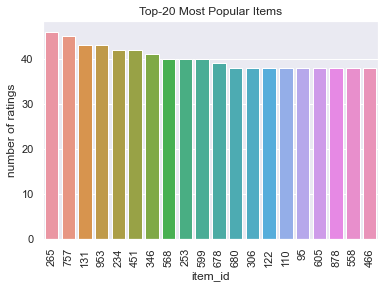

In [85]:
top20_item = dtrain.groupby("item_id")["rating"].count().sort_values(ascending = False)[:20]
g = sns.barplot(x = top20_item.index, y = top20_item, order = top20_item.index)
g.set(title = "Top-20 Most Popular Items", ylabel = "number of ratings")
g.tick_params(axis='x', rotation=90)
plt.show(g)

# Impelement Deep Learning with Keras
This part is contributed by `LAW Yiu Leung Eric 1155149315`

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Create the model
We embed both users and movies in to multi-dimensional vectors.  
The model computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias.

Math formuation: $\hat{r}_{u, i} = f_L (p_u, q_i) = A(W_l f_{l-1}(p_u, q_i) + b_l)$

In [38]:
class LFactorNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(LFactorNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.movie_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.concatenate = layers.Concatenate()
        self.dense1 = layers.Dense(100, name='fc-1', activation='relu')
        self.dense2 = layers.Dense(50, name='fc-2', activation='relu')
        self.dense3 = layers.Dense(1, name='fc-3', activation='relu')

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        concatted_vec = self.concatenate([user_vector, movie_vector])
        fc_1 = self.dense1(concatted_vec)
        fc_2 = self.dense2(fc_1)
        fc_3 = self.dense3(fc_2)
        return fc_3

## Baseline + NCF
$\hat{r}_{u, i} = \bar{r} + \bar{r}_u + \bar{r}_i + \hat{r}_{\text{NCF}}$

In [39]:
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred = glb_ave.predict(test_pair)

# user_mean
train_rating_res = train_rating - glb_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_res)
pred = pred + user_ave.predict(test_pair)

# item_mean
train_rating_res -=  user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_res)
pred = pred + item_ave.predict(test_pair)

train_rating_res -= item_ave.predict(train_pair)

Train the NCF model with 100-dimensional vectors, 20 epochs

In [40]:
model = LFactorNet(num_users=n_user, num_items=n_item, embedding_size=100)


metrics = [
    keras.metrics.MeanAbsoluteError(name='mae'),
    keras.metrics.RootMeanSquaredError(name='rmse')
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3), 
    loss=tf.keras.losses.MeanSquaredError(), 
    metrics=metrics
)

callbacks = [keras.callbacks.EarlyStopping( 
    monitor='val_rmse', min_delta=0, patience=5, verbose=1, 
    mode='auto', baseline=None, restore_best_weights=True)]

history = model.fit(
    x=train_pair,
    y=train_rating_res,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_split=.2,
)

Epoch 1/20
192/192 [==============================] - 2s 3ms/step - loss: 2.0217 - mae: 0.9021 - rmse: 1.1631 - val_loss: 1.3690 - val_mae: 0.9002 - val_rmse: 1.1674
Epoch 2/20
192/192 [==============================] - 0s 2ms/step - loss: 1.3532 - mae: 0.9019 - rmse: 1.1629 - val_loss: 1.3628 - val_mae: 0.9002 - val_rmse: 1.1674
Epoch 3/20
192/192 [==============================] - 0s 2ms/step - loss: 1.3523 - mae: 0.9019 - rmse: 1.1629 - val_loss: 1.3628 - val_mae: 0.9002 - val_rmse: 1.1674
Epoch 4/20
192/192 [==============================] - 1s 3ms/step - loss: 1.3523 - mae: 0.9019 - rmse: 1.1629 - val_loss: 1.3628 - val_mae: 0.9002 - val_rmse: 1.1674
Epoch 5/20
192/192 [==============================] - 0s 2ms/step - loss: 1.3523 - mae: 0.9019 - rmse: 1.1629 - val_loss: 1.3628 - val_mae: 0.9002 - val_rmse: 1.1674
Epoch 6/20
192/192 [==============================] - 1s 3ms/step - loss: 1.3523 - mae: 0.9019 - rmse: 1.1629 - val_loss: 1.3628 - val_mae: 0.9002 - val_rmse: 1.1674
Epoc

### RMSE of Training Dataset

In [74]:
train_pred_rating = glb_ave.predict(train_pair) + user_ave.predict(train_pair) + item_ave.predict(train_pair) + model.predict(train_pair).flatten()
rmse(train_rating, train_pred_rating)

1.1637926707361146

## Adjustment for Final Prediction

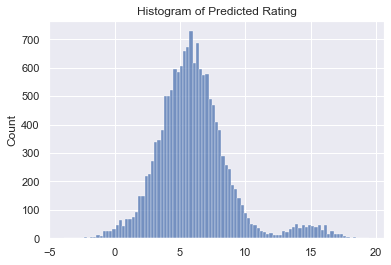

In [78]:
g = sns.histplot(x = train_pred_rating)
g.set(title = "Histogram of Predicted Rating")
plt.show(g)

We can see the distribution of the prediction is similar to training rating. However, the prediction should be within [0, 15]

### Predict within [0, 15]

In [70]:
def adjust(pred_rating, score_min, score_max):
    pred_rating_adjusted = pred_rating.copy()
    pred_rating_adjusted[pred_rating > score_max] = score_max
    pred_rating_adjusted[pred_rating < score_min] = score_min
    return pred_rating_adjusted

### Adjust the Fractional Part
If the fractioanl part < 0.1, then round it down
If the fractional part > 0.9, then round it up

In [71]:
def adjust_frac(pred_rating, frac_lower, frac_upper):
    frac = pred_rating - np.fix(pred_rating)
    
    pred_rating_adjusted = pred_rating.copy()
    pred_rating_adjusted[(frac< frac_lower) | (frac > frac_upper)] = pred_rating[(frac< frac_lower) | (frac > frac_upper)].round()
    return pred_rating_adjusted

### RMSE after Adjustment

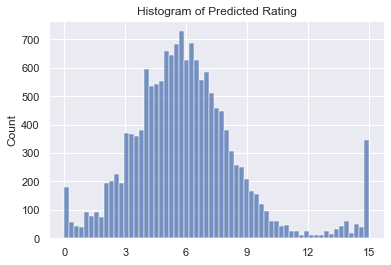

1.143303752957184

In [87]:
train_pred_rating = adjust(train_pred_rating, 0, 15)
g = sns.histplot(x = train_pred_rating)
g.set(title = "Histogram of Predicted Rating", xticks = range(0, 15+1, 3))
plt.show(g)
rmse(train_rating, train_pred_rating)

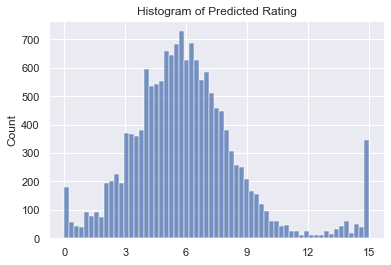

1.143303752957184

In [82]:
train_pred_rating = adjust_frac(train_pred_rating, 0.1, 0.9)
g = sns.histplot(x = train_pred_rating)
g.set(title = "Histogram of Predicted Rating", xticks = range(0, 15+1, 3))
plt.show(g)
rmse(train_rating, train_pred_rating)

We can see adjustment of the fractional part does not decrease the RMSE.

## Final Prediction

[2.48521862 4.77526723 4.7357608  ... 3.62452553 9.98011706 4.5890244 ]


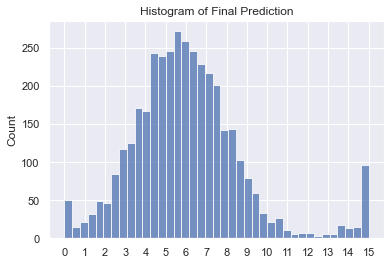

In [92]:
pred_rating = pred + model.predict(test_pair).flatten()
pred_rating = np.array(pred_rating)
pred_rating = adjust(pred_rating, 0, 15)
print(pred_rating)

g = sns.histplot(x = pred_rating)
g.set(title = "Histogram of Final Prediction", xticks = range(15+1))
plt.show(g)

# Result
This part is contributed by `TSOI Tung Sing 1155127274`
## Save to csv with timestamp

In [20]:
from datetime import datetime
nowTime = datetime.now().strftime("%Y-%m-%d_%H-%M")

method = "glb_user_item_NCF"
fileName = "predict/{method}_{nowTime}.csv".format(method = method, nowTime = nowTime)

submit = pd.DataFrame({"id": range(len(dtest)), "rating": pred_rating})
submit.to_csv(fileName, index = False)

## Print T-th record

In [93]:
t = 9315
t = 315 # there are only 3826 rows in test.csv, change t to 315

print("T-th test_pair: ", test_pair[t])
print("T-th predicted rating: ", pred_rating[t])

T-th test_pair:  [124 103]
T-th predicted rating:  1.892751620991472


## Print Top-5 Preferred Items based on `pred_rating`

In [94]:
user_id_t = test_pair[t, 0]
index = dtest[dtest["user_id"] == user_id_t].index
pred_t = pd.DataFrame({"item_id": dtest["item_id"][index], "rating": pred_rating[index]})
pred_t.sort_values("rating", ascending = False, inplace = True)
pred_t[:5]

,item_id,rating
2521,952,6.356096
2687,178,4.913444
2350,947,4.799069
255,96,4.774183
1678,295,4.392175


## Print Top-5 Preferred Items (including items may not been seen by the user)

In [95]:
test_pair_t = np.array([[user_id_t, item] for item in range(n_item)])
pred_rating_t = glb_ave.predict(test_pair_t) + user_ave.predict(test_pair_t) + item_ave.predict(test_pair_t) + model.predict(test_pair_t).flatten()
pred_t = pd.DataFrame({"item_id": range(n_item), "rating": adjust(pred_rating_t, 0, 15)})
pred_t.sort_values("rating", ascending = False, inplace = True)
pred_t[:5]

,item_id,rating
252,252,13.160800
117,117,12.661375
4,4,12.101098
653,653,10.993568
943,943,10.805256
